In [3]:
%load_ext autoreload
%autoreload 2

import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import glob
from PIL import Image
import io
from tqdm import tqdm
import re
import matplotlib.patches as mpatches
from tensorboard.backend.event_processing import event_accumulator

import os, sys
sys.path.append(os.path.join(os.getcwd(), '../sympde'))

from misc.utils import get_dict_item, read_lines


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
def get_data(filter = '', logdir = '../logs'):
    name_dirs = glob.glob(os.path.join(logdir) + '/*/*')
    data = {'_'.join(os.path.normpath(name_dir).split('/')[-2:]) : {'dir' : name_dir} for name_dir in name_dirs}

    # fitler data.keys() on regex
    pattern = re.compile(filter)
    for key in list(data.keys()):
        if not pattern.search(key):
            data.pop(key)

    return data

In [5]:
def get_results_test_loss(version_dir, split = 'val'):
    for filename in os.listdir(version_dir):
        if 'events.out.tfevents' in filename:
            # Initialize an event accumulator.
            event_file_path = os.path.join(version_dir, filename)
            ea = event_accumulator.EventAccumulator(event_file_path,
                                                    size_guidance={event_accumulator.SCALARS: 0})

            # Load the data from the event file.
            ea.Reload()

            # Extract 'test_loss' values.
            if 'test_loss' in ea.scalars.Keys():
                test_loss_values = ea.scalars.Items('test_loss')
                for value in test_loss_values:
                    print(f"Step: {value.step}, Test Loss: {value.value}")
            else:
                print("test_loss not found in the event file")

    return None, None, None, None

def get_results(version_dir, split = 'val', test_loss: bool = False):


    if test_loss:
        return get_results_test_loss(version_dir, split = split)


    val_loss = []
    val_plot = []
    test_loss = []
    test_Lmse = []

    for filename in os.listdir(version_dir):

        if 'events.out.tfevents' in filename:

            file_path = os.path.join(version_dir, filename)
            raw_dataset = tf.data.TFRecordDataset(file_path)

            try:
                for raw_record in raw_dataset:
                    event = tf.compat.v1.Event.FromString(raw_record.numpy())
                    for v in event.summary.value:
                        if v.tag == f'val_loss':
                            val_loss.append(v.simple_value)
                        
                        if v.tag == f'test_Lmse':
                            test_Lmse.append(v.simple_value)

                        # if v.tag == f'val_plot':
                        #     image_enc = v.image.encoded_image_string
                        #     image = Image.open(io.BytesIO(image_enc))
                        #     val_plot.append(image)

                        if v.tag == f'test_loss':
                            test_loss.append(v.simple_value)
            except:
                continue

    
    val_loss = np.array(val_loss)
    test_loss = np.array(test_loss)
    test_Lmse = np.array(test_Lmse)
    return val_loss, val_plot, test_loss, test_Lmse

def get_hparams(version):
    _, _, dim, r, digit, _, = version.split('_')
    dim = int(dim.replace('dim', ''))
    r = float(r.replace('r', ''))
    digit = digit.replace('digit', '')
    digit = int(digit) if digit != 'all' else digit
    return dim, r, digit

In [6]:
def get_metrics(data):
    for version, version_dict in tqdm(data.items()):
        # version_dict['val_loss'], version_dict['val_plot'], version_dict['test_loss'], version_dict['test_Lmse']  = get_results(version_dict['dir'])
        version_dict['test_loss'] = get_results(version_dict['dir'], test_loss=True)
        # version_dict['color'] = get_color(version)
        version_dict['dim'], version_dict['r'], version_dict['digit'] = get_hparams(version)
    return data

In [7]:
def plot_testloss(data, print_loss = False):
    plt.style.use('default')

    test_loss_noaug = []
    test_loss_aug = []

    for k, v in data.items():
        loss = v['test_loss']
        if len(loss) == 0:
            continue
        if 'aug0_' in k:
            test_loss_noaug.append(loss)
        else:
            test_loss_aug.append(loss)

    test_loss_noaug = np.array(test_loss_noaug).flatten()
    test_loss_aug = np.array(test_loss_aug).flatten()

    if print_loss:
        print('No Aug: ', test_loss_noaug)
        print('Aug:    ', test_loss_aug)

    plt.figure(figsize=(3,4))
    bins = None
    plt.hist(test_loss_noaug, label='No Aug', alpha = 0.5, bins = bins, color = 'tab:blue')
    # _, bins, _ = plt.hist(test_loss_noaug, label='No Aug', alpha = 0.5, bins = bins, color = 'tab:blue')
    plt.hist(test_loss_aug, label='Aug', alpha = 0.5, bins = bins, color = 'tab:orange')
    plt.legend()
    plt.show()

In [8]:
def parse_arguments_to_dict(arg_list):
    """
    Parses a list of argument strings into a list of dictionaries.

    Each string in the list is expected to have a format like '--key value',
    and this function will convert these strings into dictionaries where
    each key-value pair is an entry.

    :param arg_list: List of argument strings.
    :return: List of dictionaries with parsed key-value pairs.
    """
    parsed_list = []

    for arg_str in arg_list:
        # Split the string into individual arguments
        args = arg_str.strip().split('--')
        args_dict = {}

        for arg in args:
            if arg:
                # Split each argument into key and value
                key, value = arg.strip().split(maxsplit=1)
                args_dict[key] = value

        parsed_list.append(args_dict)

    return parsed_list

In [9]:
data = get_data(filter = 'datav1.*version_1')
keys = list(data.keys())
print(len(keys))
print(keys)

18
['datav1_netFNO1d_Pde2_aug0_seed3_version_1', 'datav1_netFNO1d_Pde3_aug0_seed2_version_1', 'datav1_netFNO1d_Pde3_aug0_seed1_version_1', 'datav1_netFNO1d_Pde18_aug0_seed1_version_1', 'datav1_netFNO1d_Pde1_aug0_seed3_version_1', 'datav1_netFNO1d_Pde2_aug0_seed2_version_1', 'datav1_netFNO1d_KdV_aug0_seed3_version_1', 'datav1_netFNO1d_KdV_aug0_seed2_version_1', 'datav1_netFNO1d_KdV_aug0_seed1_version_1', 'datav1_netFNO1d_Pde24_aug0_seed1_version_1', 'datav1_netFNO1d_Pde2_aug0_seed1_version_1', 'datav1_netFNO1d_Pde1_aug0_seed2_version_1', 'datav1_netFNO1d_Pde1_aug0_seed1_version_1', 'datav1_netFNO1d_Pde24_aug0_seed2_version_1', 'datav1_netFNO1d_Pde4_aug0_seed1_version_1', 'datav1_netFNO1d_Pde3_aug0_seed3_version_1', 'datav1_netFNO1d_Pde22_aug0_seed3_version_1', 'datav1_netFNO1d_Pde24_aug0_seed3_version_1']


In [124]:
data = get_metrics(data)

100%|██████████| 48/48 [00:21<00:00,  2.23it/s]


In [110]:
digits = np.unique(np.array([v['digit'] for v in data.values()]))
rs = np.unique(np.array([v['r'] for v in data.values()]))
dims = np.unique(np.array([v['dim'] for v in data.values()]))

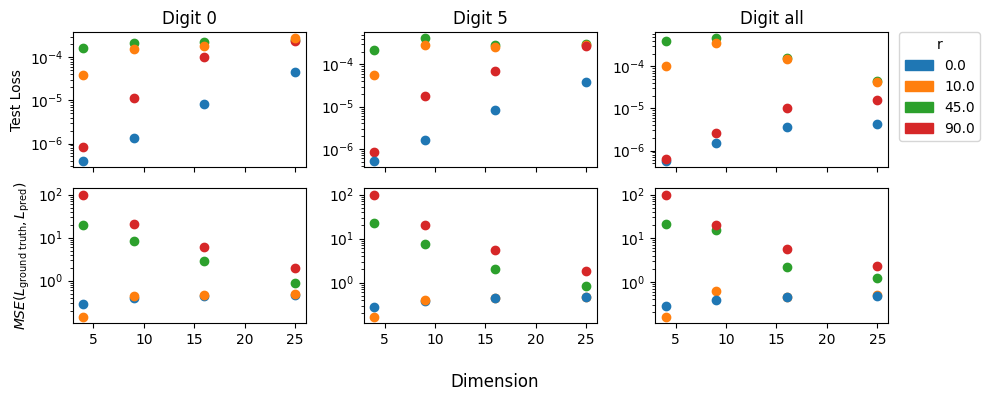

In [125]:
fig, axs = plt.subplots(2, len(digits), figsize=(10, 4), tight_layout=True, sharey=False, sharex=True)

axs_dict = {digit : ax for digit, ax in zip(digits, axs.T)}
color_dict = {r : plt.cm.tab10(i) for i, r in enumerate(rs)}
patches = [mpatches.Patch(color = color, label = r) for r, color in color_dict.items()]

for k, v in data.items():
    if len(v['test_loss']) == 0:
        print(k, 'has no test loss')
    axs_dict[str(v['digit'])][0].scatter(v['dim'], v['test_loss'], color = color_dict[v['r']], label = v['r'])
    axs_dict[str(v['digit'])][0].set_yscale('log')
    axs_dict[str(v['digit'])][1].scatter(v['dim'], v['test_Lmse'], color = color_dict[v['r']], label = v['r'])
    axs_dict[str(v['digit'])][1].set_yscale('log')
    axs_dict[str(v['digit'])][0].set_title(f'Digit {v["digit"]}')

fig.supxlabel('Dimension')
axs[0, 0].set_ylabel('Test Loss')
axs[1, 0].set_ylabel(r'$MSE(L_\text{ground truth}, L_\text{pred})$')
# fig.supylabel('Test Loss')
axs.T[-1, 0].legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title = 'r')
plt.show()


Text(0, 0.5, '$MSE(L_\\text{gt}, L_\\text{pred})$')

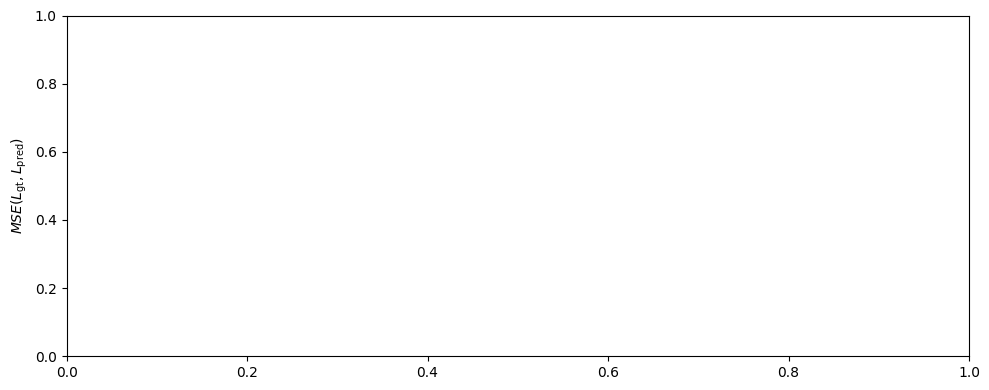

In [119]:
plt.figure(figsize=(10, 4), tight_layout=True)
plt.ylabel(r'$MSE(L_\text{ground truth}, L_\text{pred})$')

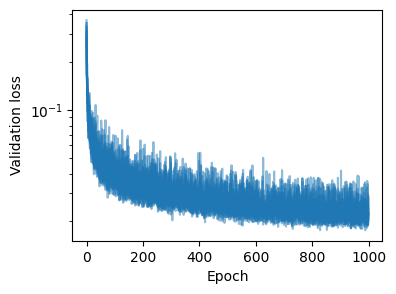

In [53]:
plt.style.use('default')


fig, axs = plt.subplots(1, 1, figsize=(4, 3))
for version, version_dict in data.items():

    if version[-1] ==  get_dict_item(data)[0][-1]:  # only one version needed for label
        if 'aug0_' in version:
            label = 'Augmentation'
        else:
            label = 'No augmentation'
    else:
        label = ''

    axs.plot(version_dict['val_loss'], label=label, color=version_dict['color'], alpha = 0.5)
axs.set_xlabel('Epoch')
axs.set_ylabel('Validation loss')
axs.set_yscale('log')
# axs.legend()
plt.show()

In [54]:
n_iterations = get_dict_item(data)[1]['val_loss'].shape[0]
val_losses = np.full((2, len(data)//2, n_iterations), np.nan)
test_losses = np.full((2, len(data)//2, 1), np.nan)
print(val_losses.shape)

(2, 5, 1000)


In [56]:
for version, version_dict in data.items():
    i_aug = 0 if 'aug0_' in version else 1
    seed = int(version[int(version.find('seed') + 4)])
    val_losses[i_aug, seed-1] = version_dict['val_loss']
    test_losses[i_aug, seed-1] = version_dict['test_loss']

assert np.isnan(val_losses).sum() == 0


In [57]:
means, stds = np.mean(test_losses, axis = 1).reshape(-1), np.std(test_losses, axis = 1).reshape(-1)
for mean, std in zip(means, stds):
    print(f"{mean:.4f} ± {std:.4f}")

0.0342 ± 0.0011
0.0324 ± 0.0026


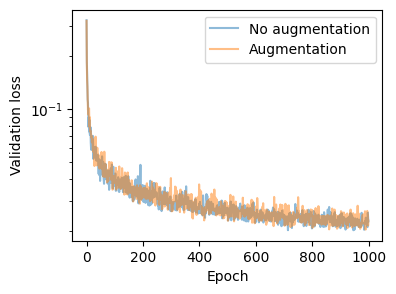

In [58]:
colors = ['tab:blue', 'tab:orange']
labels = ['No augmentation', 'Augmentation']


fig, ax = plt.subplots(1, 1, figsize=(4, 3))

for i, val_loss_aug in enumerate(val_losses):
    mean = val_loss_aug.mean(axis = 0)
    std = val_loss_aug.std(axis = 0)

    ax.plot(mean, color = colors[i], label = labels[i], alpha = 0.5)
    # ax.fill_between(np.arange(len(mean)), mean-std, mean+std, alpha = 0.5, color = colors[i])

ax.set_xlabel('Epoch')
ax.set_ylabel('Validation loss')
ax.set_yscale('log')
ax.legend()
plt.show()

### More plots

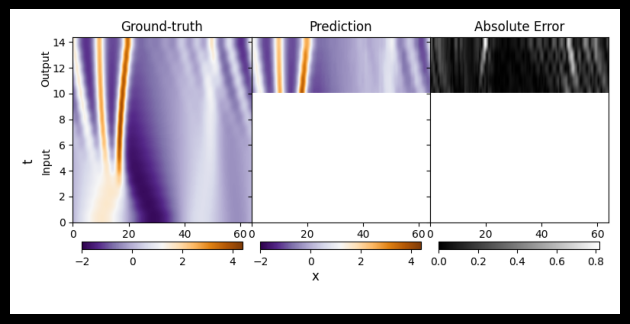

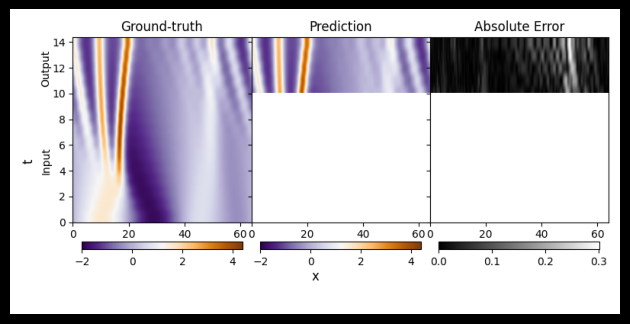

In [101]:
keys = ['FNO1d_precision_datasympde_aug0_KdV_seed4', 'FNO1d_precision_datasympde_aug1_KdV_seed4']
for key in keys:
    images = data[key]['val_plot']
    im = images[-1]
    plt.figure(tight_layout=True)
    plt.imshow(im)
    plt.axis('off')
    plt.show()